In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import json

import sys
sys.path.append('/home/jshe/prop-pred/src/data')
from data_utils import *


from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

%load_ext autoreload
%autoreload 2

## Data

In [2]:
datadir = '../../data/regress_immuno'
data = to_namedtuple(load_data(datadir))

In [3]:
train_X = np.concatenate((
    #data.train.embeddings, 
    data.train.fingerprints, 
), axis=1)
validation_X = np.concatenate((
    #data.validation.embeddings, 
    data.validation.fingerprints, 
), axis=1)
test_X = np.concatenate((
    #data.test.embeddings, 
    data.test.fingerprints, 
), axis=1)

In [4]:
train_Y = np.concatenate((
    data.train.y, 
    #data.train.y_rdkit, 
), axis=1)
validation_Y = np.concatenate((
    data.validation.y, 
    #data.validation.y_rdkit
), axis=1)
test_Y = np.concatenate((
    data.test.y, 
    #data.test.y_rdkit, 
), axis=1)

## Train

In [5]:
with open('./hyperparameters.json') as f:
    hyperparameters = json.load(f)

In [6]:
multi_xgbr = MultiOutputRegressor(
    XGBRegressor(**hyperparameters)
)
multi_xgbr.fit(train_X, train_Y)

MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.05,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.01, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None, min_child_weight=3,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [7]:
print(f'Score: {multi_xgbr.score(test_X, test_Y)}')

Score: 0.09032586074742924


## Test

In [8]:
x = test_X
y_true = test_Y

In [9]:
y_pred = multi_xgbr.predict(x)
scores = r2_score(y_true, y_pred, multioutput='raw_values')
print(scores)

[ 0.19719048  0.03234513  0.09460641  0.09557277  0.062818   -0.00837182
  0.15812005]


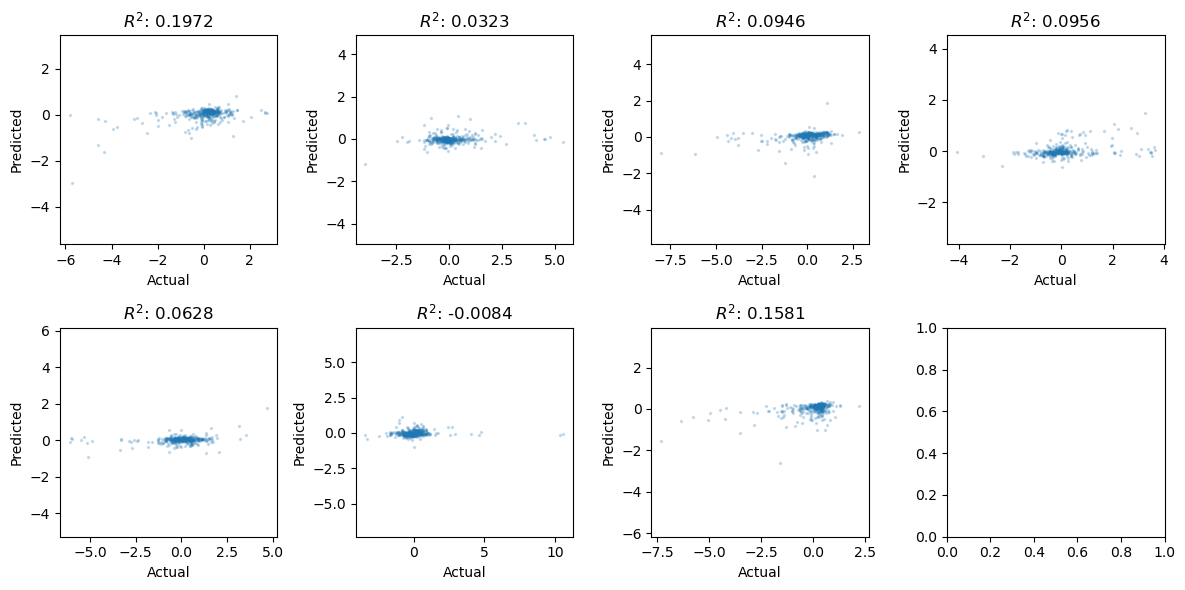

In [10]:
n_rows = n_cols = int((y_pred.shape[1]) ** 0.5)
while (n_rows * n_cols) < y_pred.shape[1]: n_cols += 1

fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
axs = [axs] if y_pred.shape[1] == 1 else axs.flatten()

for i in range(y_pred.shape[1]):

    ax = axs[i]

    ax.scatter(y_true[:, i], y_pred[:, i], s=2, alpha=0.2)
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    ax.set_title(f'$R^2$: {scores[i]:.4f}')
    ax.set_aspect('equal', adjustable='datalim')

plt.tight_layout()